#Importations

In [ ]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict
from google.cloud import storage

### Utilitaires
from tqdm import tqdm
import os


In [ ]:
import os
import shutil
from google.cloud import storage

# Nom Bucket
bucket_name = 'data-train-mimir'

# Fonction pour nettoyer un répertoire
def clean_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
        print(f'Nettoyé le répertoire : {directory}')
    os.makedirs(directory)
    print(f'Créé le répertoire : {directory}')

# Fonction pour télécharger les blobs depuis GCS et préserver la structure des répertoires
def download_blobs(bucket_name, source_blob_folder, destination_folder):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=source_blob_folder)

    for blob in blobs:
        if not blob.name.endswith('/'):
            # Créer le chemin local correspondant au blob
            destination_path = os.path.join(destination_folder, os.path.relpath(blob.name, source_blob_folder))
            os.makedirs(os.path.dirname(destination_path), exist_ok=True)
            blob.download_to_filename(destination_path)
            print(f'Downloaded {blob.name} to {destination_path}')

# Nettoyer les répertoires de train et test
clean_directory('data/train')
clean_directory('data/test')

# Téléchargement des blobs depuis le dossier 'data/train' du bucket GCS vers le dossier local 'data/train'
download_blobs(bucket_name, 'data/train', 'data/train')

# Téléchargement des blobs depuis le dossier 'data/test' du bucket GCS vers le dossier local 'data/test'
download_blobs(bucket_name, 'data/test', 'data/test')


# Modèle binaire 3

In [ ]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict
from google.cloud import storage

### Traitement d'images
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

### Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

### Prétraitement et manipulation de données
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

### Modélisation avec Keras et TensorFlow
import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import keras.backend as K

# TensorFlow Keras specific
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical

# Keras applications
from keras.applications.resnet import ResNet50

### Utilitaires
from tqdm import tqdm
import os


In [ ]:
# Afficher le chemin des fichiers téléchargés
for dirname, _, filenames in os.walk('data/train'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Initialiser les listes pour stocker les chemins d'images et les labels
images = []
labels = []

# Parcourir les sous-dossiers pour récupérer les chemins d'images et les labels
for subfolder in tqdm(os.listdir('data')):
    subfolder_path = os.path.join('data', subfolder)
    if os.path.isdir(subfolder_path):
        for folder in os.listdir(subfolder_path):
            subfolder_path2 = os.path.join(subfolder_path, folder)
            if os.path.isdir(subfolder_path2):
                for image_filename in os.listdir(subfolder_path2):
                    image_path = os.path.join(subfolder_path2, image_filename)
                    images.append(image_path)
                    labels.append(folder)
            else:
                images.append(subfolder_path2)
                labels.append(subfolder)
    else:
        images.append(subfolder_path)
        labels.append(subfolder)

# Vérifiez le nombre d'images chargées
print(f"\nNombre total d'images chargées : {len(images)}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
data/train/MildDemented/mildDem350.jpg
data/train/MildDemented/mildDem290.jpg
data/train/MildDemented/mildDem160.jpg
data/train/MildDemented/mildDem371.jpg
data/train/MildDemented/mildDem72.jpg
data/train/MildDemented/mildDem652.jpg
data/train/MildDemented/image de test_patient_image
data/train/MildDemented/mildDem516.jpg
data/train/MildDemented/mildDem471.jpg
data/train/MildDemented/mildDem2.jpg
data/train/MildDemented/mildDem519.jpg
data/train/MildDemented/mildDem488.jpg
data/train/MildDemented/mildDem102.jpg
data/train/MildDemented/mildDem660.jpg
data/train/MildDemented/mildDem185.jpg
data/train/MildDemented/mildDem466.jpg
data/train/MildDemented/mildDem324.jpg
data/train/MildDemented/mildDem625.jpg
data/train/MildDemented/mildDem319.jpg
data/train/MildDemented/mildDem165.jpg
data/train/MildDemented/mildDem591.jpg
data/train/MildDemented/mildDem276.jpg
data/train/MildDemented/mildDem423.jpg
data/train/Mild

100%|██████████| 2/2 [00:00<00:00, 126.65it/s]


Nombre total d'images chargées : 6404


#Entraînement modèle binaire 3

DataFrame avant filtrage :
                                image         label
0  data/test/MildDemented/29 (16).jpg  MildDemented
1  data/test/MildDemented/27 (18).jpg  MildDemented
2  data/test/MildDemented/32 (19).jpg  MildDemented
3   data/test/MildDemented/31 (3).jpg  MildDemented
4   data/test/MildDemented/27 (2).jpg  MildDemented
DataFrame après filtrage :
                                image         label
0  data/test/MildDemented/29 (16).jpg  MildDemented
1  data/test/MildDemented/27 (18).jpg  MildDemented
2  data/test/MildDemented/32 (19).jpg  MildDemented
3   data/test/MildDemented/31 (3).jpg  MildDemented
4   data/test/MildDemented/27 (2).jpg  MildDemented


<ipython-input-3-5e5020c4c20e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = label_encoder.fit_transform(df['label'])
<ipython-input-3-5e5020c4c20e>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].astype(str)
<ipython-input-3-5e5020c4c20e>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df.label, palett

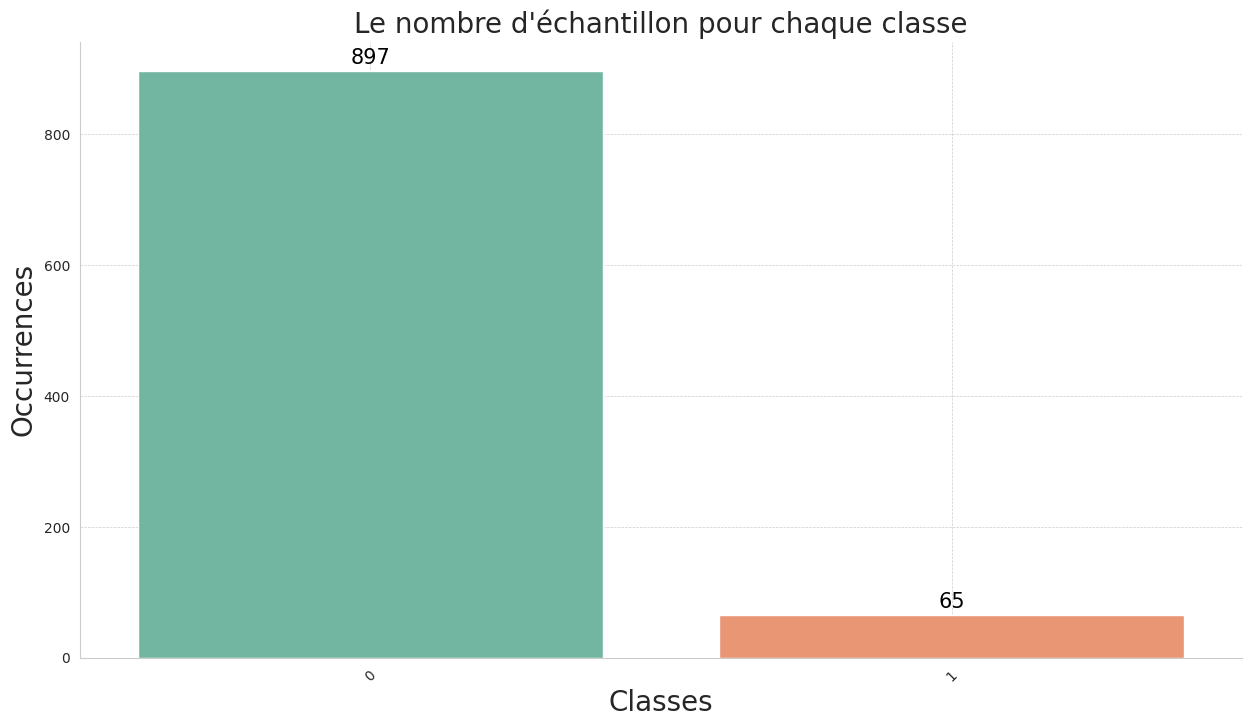

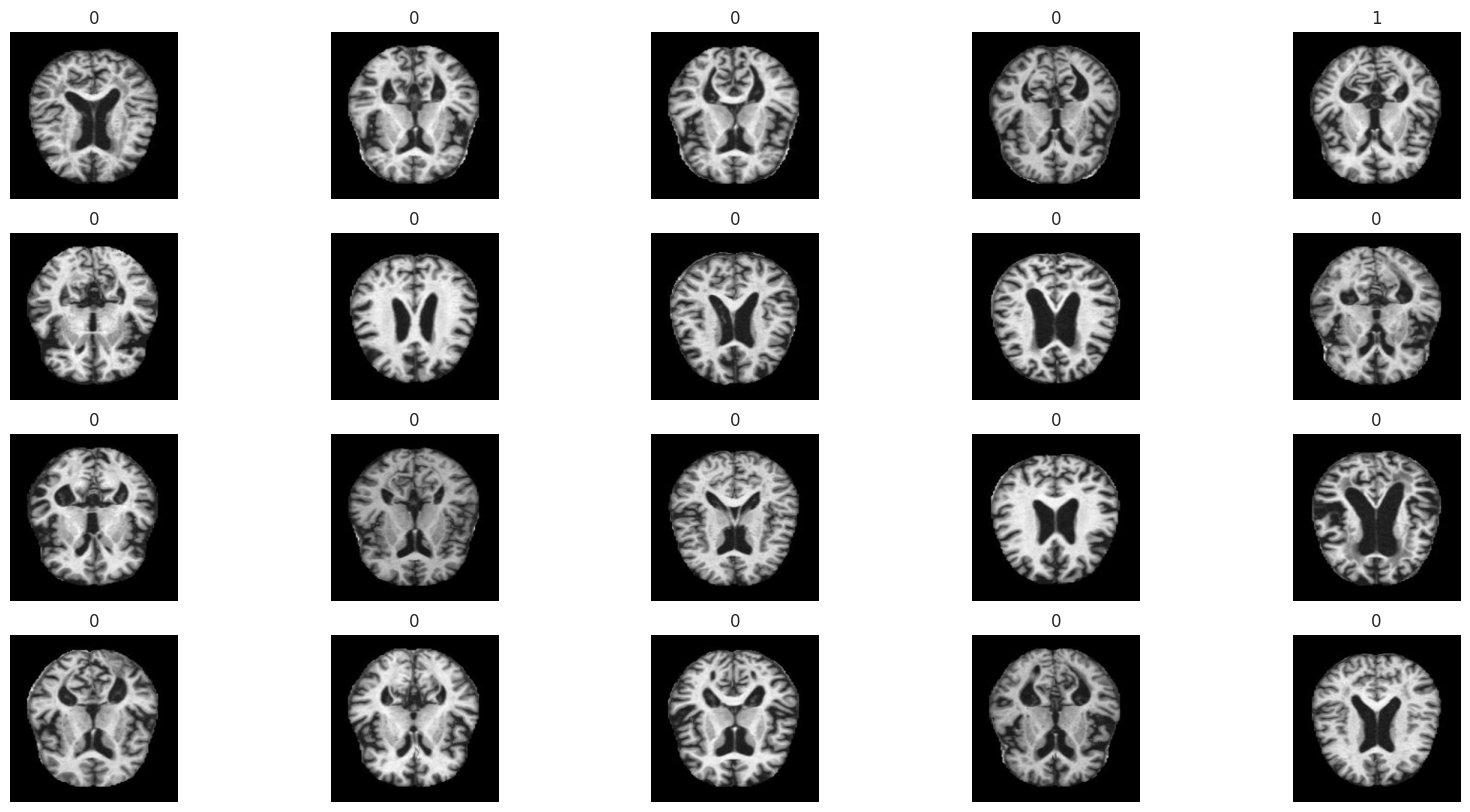

Found 960 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


(1792, 176, 176, 3) (1792, 2)


<ipython-input-3-5e5020c4c20e>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=labels, palette='Set1')


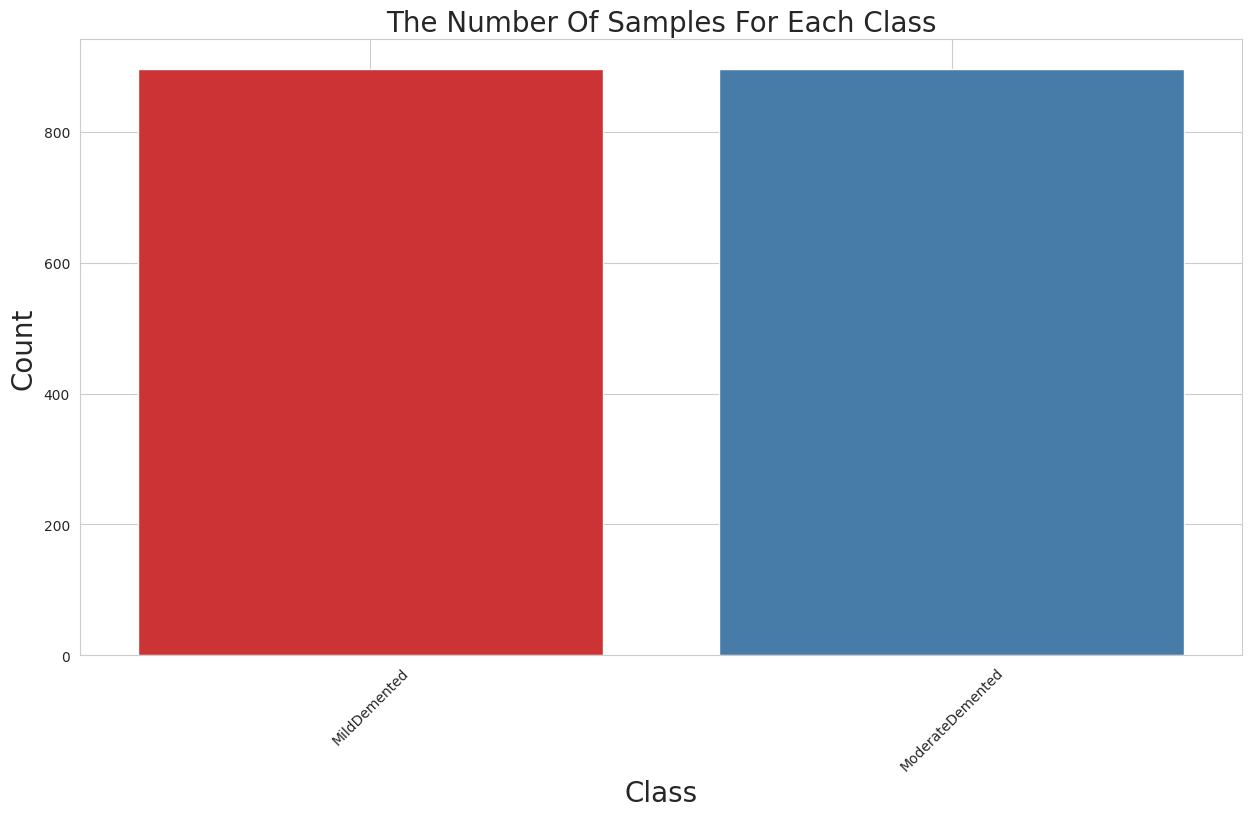

X_train shape is  (1254, 176, 176, 3)
X_test shape is  (269, 176, 176, 3)
y_train shape is  (1254, 2)
y_test shape is  (269, 2)
94765736/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 6, 6, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 batch_normalization (Batch  (None, 73728)             294912    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 32)                235932

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 14s 222ms/step - loss: 0.2464 - accuracy: 0.8947 - val_loss: 1.5982 - val_accuracy: 0.5019
Epoch 2/100
40/40 [==============================] - 8s 201ms/step - loss: 0.0783 - accuracy: 0.9841 - val_loss: 0.6398 - val_accuracy: 0.6208
Epoch 3/100
40/40 [==============================] - 8s 199ms/step - loss: 0.0463 - accuracy: 0.9936 - val_loss: 0.2791 - val_accuracy: 0.8736
Epoch 4/100
40/40 [==============================] - 8s 201ms/step - loss: 0.0345 - accuracy: 0.9920 - val_loss: 0.1085 - val_accuracy: 0.9777
Epoch 5/100
40/40 [==============================] - 8s 200ms/step - loss: 0.0309 - accuracy: 0.9944 - val_loss: 0.0601 - val_accuracy: 0.9926
Epoch 6/100
40/40 [==============================] - 8s 198ms/step - loss: 0.0306 - accuracy: 0.9952 - val_loss: 0.0390 - val_accuracy: 0.9926
Epoch 7/100
40/40 [==============================] - 8s 198ms/step - loss: 0.0205 - accuracy: 0.9984 - val_loss: 0.0246 - val_accuracy: 0.9963
Epoch 8/10

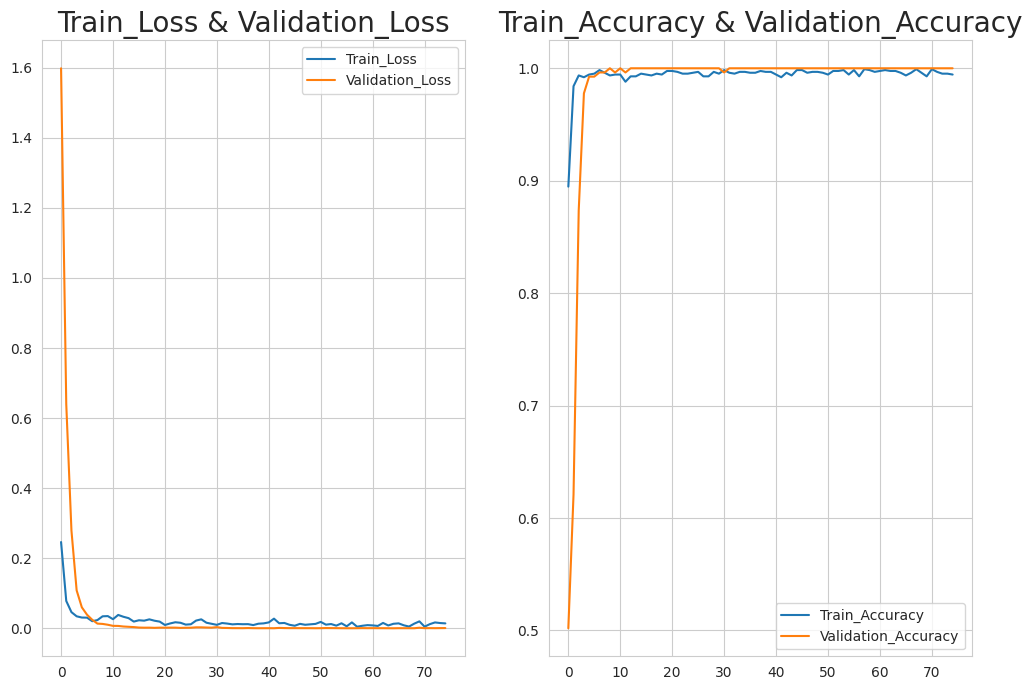

9/9 [==============================] - 2s 149ms/step - loss: 1.8200e-04 - accuracy: 1.0000
Test Loss = 0.00018199844635091722
Test Accuracy = 1.0
9/9 [==============================] - 2s 154ms/step
Classification Report is :                    precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00       134
ModerateDemented       1.00      1.00      1.00       135

        accuracy                           1.00       269
       macro avg       1.00      1.00      1.00       269
    weighted avg       1.00      1.00      1.00       269



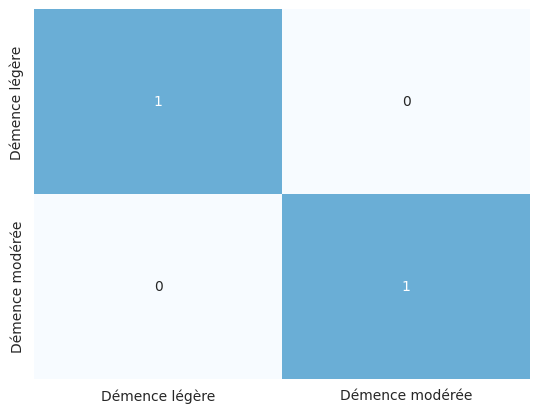

In [ ]:
# Créer un DataFrame à partir des chemins d'images et des labels
df = pd.DataFrame({'image': images, 'label': labels})

# Afficher les premières lignes du DataFrame
print("DataFrame avant filtrage :")
print(df.head())

# Filtrer les classes nécessaires
df = df[df['label'].isin(['MildDemented', 'ModerateDemented'])]

# Afficher les premières lignes du DataFrame après filtrage
print("DataFrame après filtrage :")
print(df.head())

# Réinitialiser l'index
df.reset_index(drop=True, inplace=True)

# Vérifiez si le DataFrame est vide
if df.empty:
    print("Erreur : le DataFrame est vide après le filtrage. Vérifiez les classes spécifiées et les données d'entrée.")
else:
    # Encoder les labels
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])

    # Convertir les labels encodés en chaînes de caractères
    df['label'] = df['label'].astype(str)

    # Graphique
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 8))
    ax = sns.countplot(x=df.label, palette='Set2')

    # Ajouter des étiquettes et un titre
    ax.set_xlabel("Classes", fontsize=20)
    ax.set_ylabel("Occurrences", fontsize=20)
    plt.title('Le nombre d\'échantillon pour chaque classe', fontsize=20)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45)

    # Ajouter des annotations à chaque barre
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline',
                    fontsize=15, color='black', xytext=(0, 5),
                    textcoords='offset points')

    # Retirer les bordures supérieures et droites
    sns.despine()
    plt.show()

    # Afficher des exemples d'images
    plt.figure(figsize=(20, 10))
    for n, i in enumerate(np.random.randint(0, len(df), 20)):
        plt.subplot(4, 5, n + 1)
        img = cv2.imread(df.image[i])
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        plt.title(df.label[i], fontsize=12)
    plt.show()

    Size = (176, 176)
    work_dr = ImageDataGenerator(rescale=1./255)
    train_data_gen = work_dr.flow_from_dataframe(df, x_col='image', y_col='label', target_size=Size, batch_size=6500, shuffle=False)

    for i in range(len(train_data_gen)):
        train_data, train_labels = train_data_gen[i]

    class_num = np.sort(['MildDemented', 'ModerateDemented'])

    # Rééchantillonner avec SMOTE
    sm = SMOTE(random_state=42)
    train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
    train_data = train_data.reshape(-1, 176, 176, 3)
    train_labels = to_categorical(train_labels, num_classes=2)
    print(train_data.shape, train_labels.shape)

    # Mettre à jour les labels après SMOTE
    labels = [class_num[i] for i in np.argmax(train_labels, axis=1)]

    # Afficher le graphique de comptage des classes rééchantillonnées
    plt.figure(figsize=(15, 8))
    ax = sns.countplot(x=labels, palette='Set1')
    ax.set_xlabel("Class", fontsize=20)
    ax.set_ylabel("Count", fontsize=20)
    plt.title('The Number Of Samples For Each Class', fontsize=20)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

    X_train, X_test1, y_train, y_test1 = train_test_split(train_data, train_labels, test_size=0.3, random_state=42, shuffle=True, stratify=train_labels)
    X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42, shuffle=True, stratify=y_test1)
    print('X_train shape is ', X_train.shape)
    print('X_test shape is ', X_test.shape)
    print('y_train shape is ', y_train.shape)
    print('y_test shape is ', y_test.shape)


    class_num = 2
    input_shape = (176, 176, 3)
    base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=Input(shape=input_shape))

    for layer in base_model.layers:
        layer.trainable = False

    # Construire le modèle
    model = tf.keras.Sequential()
    model.add(base_model)
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(32, kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(class_num, activation='softmax'))
    model.build((None,) + input_shape)
    ResNet = model
    ResNet.summary()

    # Configurer les callbacks et compiler le modèle
    checkpoint_cb = ModelCheckpoint("models/ResNet50_binaire_3.h5", save_best_only=True)
    early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)
    ResNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Entraîner le modèle
    hist = ResNet.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb])

    # Charger le meilleur modèle sauvegardé
    ResNet = load_model('models/ResNet50_binaire_3.h5')

    # Afficher les résultats de l'entraînement
    hist_ = pd.DataFrame(hist.history)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(hist_['loss'], label='Train_Loss')
    plt.plot(hist_['val_loss'], label='Validation_Loss')
    plt.title('Train_Loss & Validation_Loss', fontsize=20)
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(hist_['accuracy'], label='Train_Accuracy')
    plt.plot(hist_['val_accuracy'], label='Validation_Accuracy')
    plt.title('Train_Accuracy & Validation_Accuracy', fontsize=20)
    plt.legend()
    plt.show()

    # Évaluer le modèle sur le jeu de test
    score, acc = ResNet.evaluate(X_test, y_test)
    print('Test Loss =', score)
    print('Test Accuracy =', acc)

    # Faire des prédictions
    predictions = ResNet.predict(X_test)
    y_pred = np.argmax(predictions, axis=1)
    y_test_ = np.argmax(y_test, axis=1)
    df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})

    # Matrice de confusion
    CM = confusion_matrix(y_test_, y_pred)
    CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
    sns.heatmap(CM_percent, fmt='g', center=True, cbar=False, annot=True, cmap='Blues', xticklabels=['Démence légère', 'Démence modérée'], yticklabels=['Démence légère', 'Démence modérée'])
    CM

    # Rapport de classification
    ClassificationReport = classification_report(y_test_, y_pred, target_names=label_encoder.classes_)
    print('Classification Report is : ', ClassificationReport)

In [ ]:
from google.cloud import storage

# Fonction pour télécharger un fichier local vers GCS
def upload_to_gcs(local_file_path, bucket_name, gcs_destination_path):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(gcs_destination_path)
    blob.upload_from_filename(local_file_path)
    print(f'Uploaded {local_file_path} to {gcs_destination_path} in bucket {bucket_name}')

# Spécifiez le chemin local et GCS pour le modèle
local_model_path = "models/ResNet50_binaire_3.h5"
bucket_name = 'data-train-mimir'
gcs_model_path = 'models/ResNet50_binaire_3.h5'

# Téléchargez le modèle enregistré localement vers GCS
upload_to_gcs(local_model_path, bucket_name, gcs_model_path)


Uploaded models/ResNet50_binaire_3.h5 to models/ResNet50_binaire_3.h5 in bucket data-train-mimir


## Evaluation

100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


6/6 [==============================] - 1s 156ms/step - loss: 1.2521e-04 - accuracy: 1.0000
Accuracy on new test data: 1.0
Loss on new test data: 0.0001252107322216034
6/6 [==============================] - 1s 152ms/step
                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00       179
ModerateDemented       1.00      1.00      1.00        12

        accuracy                           1.00       191
       macro avg       1.00      1.00      1.00       191
    weighted avg       1.00      1.00      1.00       191



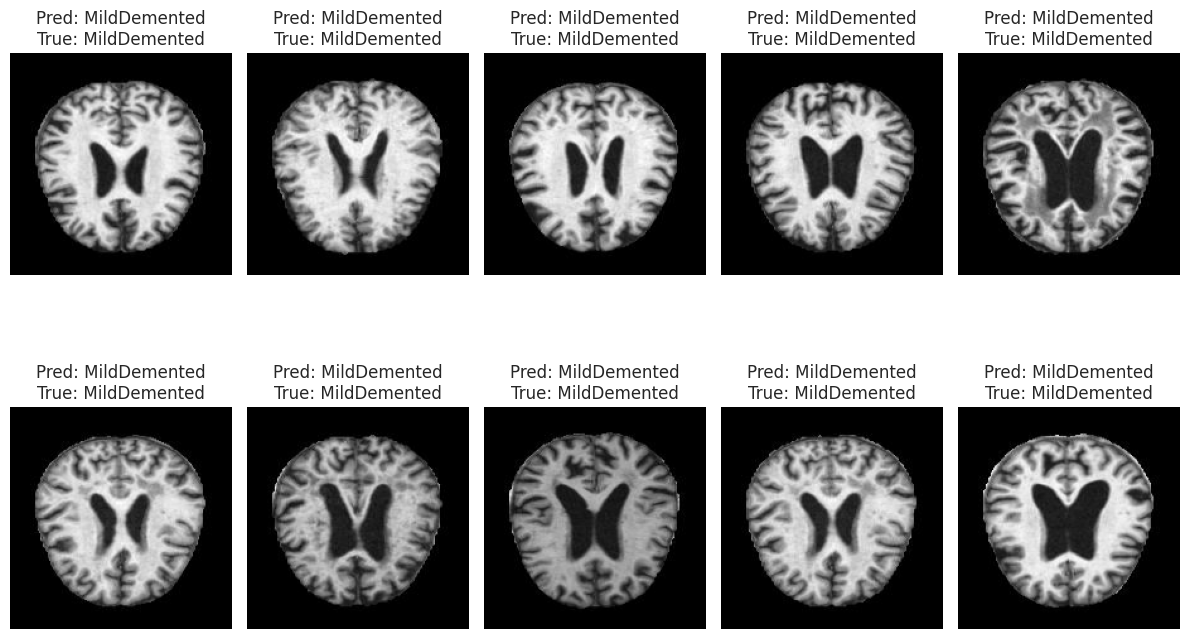

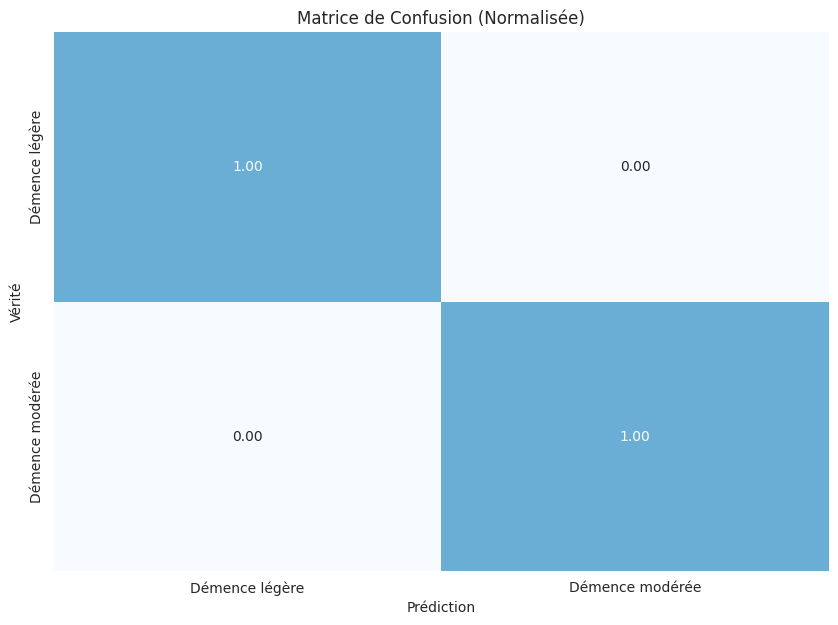

Uploaded confusion_matrix_model3.png to static/confusion_matrix_model3.png in bucket data-train-mimir


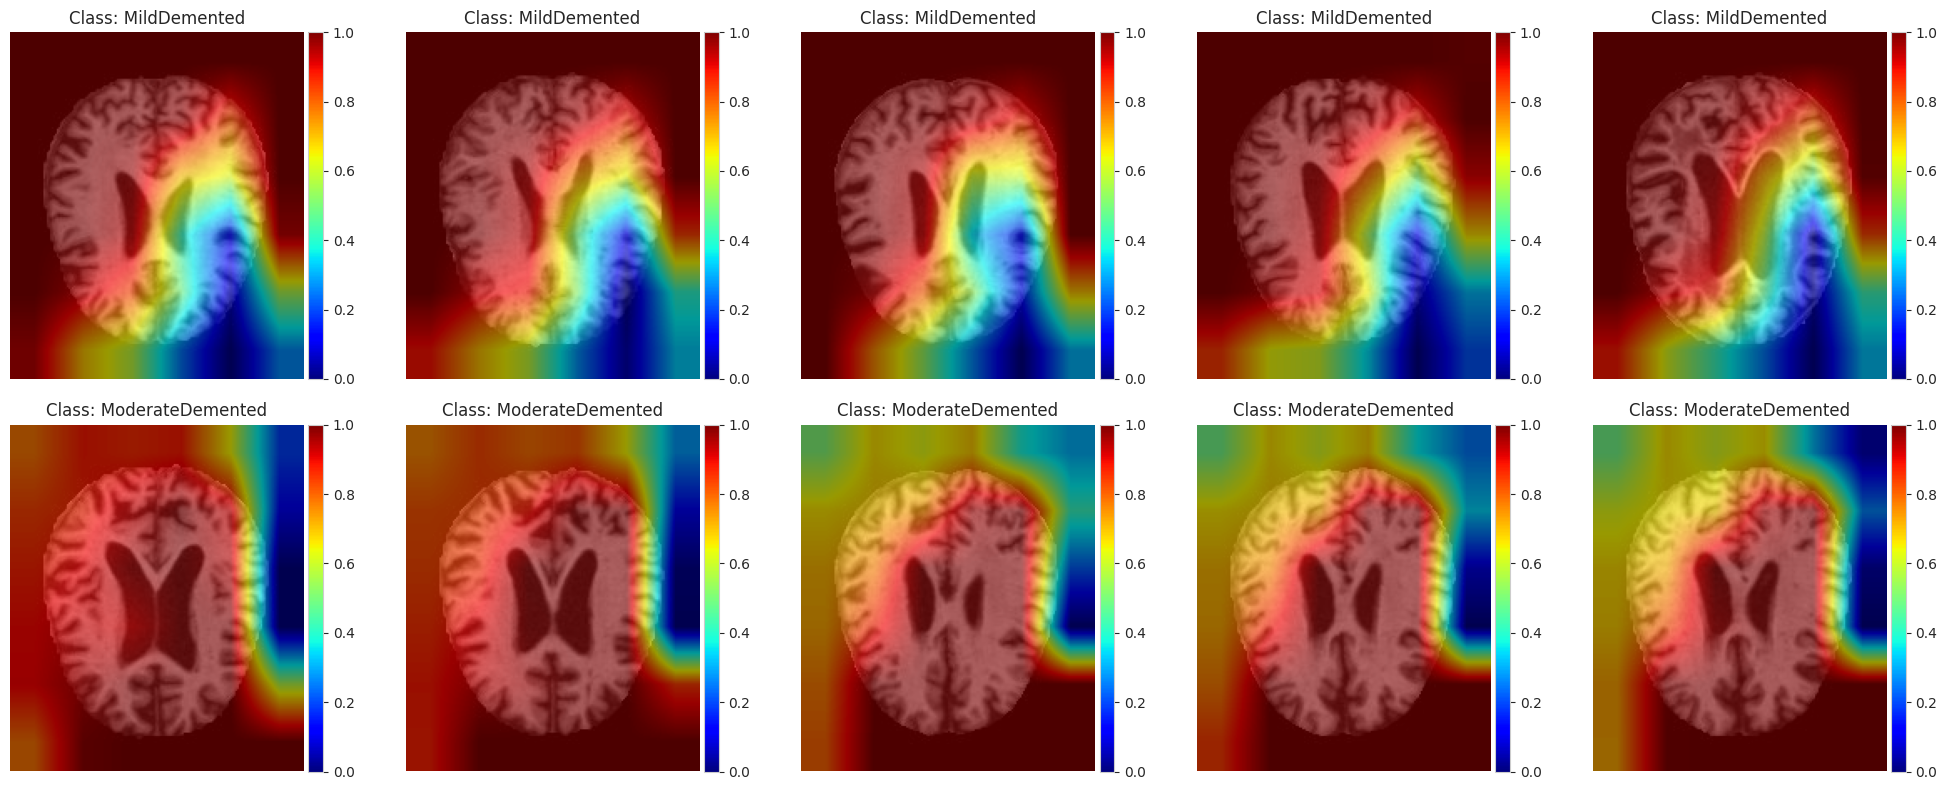

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Chemin vers le dossier des nouvelles données de test
test_data_dir = 'data/test'

# Prétraitement des nouvelles données de test
new_test_images = []
new_test_labels = []
image_paths = []

for subfolder in tqdm(os.listdir(test_data_dir)):
    subfolder_path = os.path.join(test_data_dir, subfolder)
    if os.path.isdir(subfolder_path):
        for file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (176, 176))  # Utilisez la même taille que celle utilisée pour l'entraînement
                new_test_images.append(img)
                new_test_labels.append(subfolder)
                image_paths.append(img_path)

# Filtrer les classes nécessaires pour les données de test
filtered_test_data = [(img, label, path) for img, label, path in zip(new_test_images, new_test_labels, image_paths) if label in ['MildDemented', 'ModerateDemented']]
if not filtered_test_data:
    print("Erreur : aucune image de test trouvée pour les classes spécifiées.")
else:
    new_test_images, new_test_labels, image_paths = zip(*filtered_test_data)

    new_test_images = np.array(new_test_images)
    new_test_labels = np.array(new_test_labels)

    # Normalisation des images de test
    new_test_images = new_test_images / 255.0

    # Encodage des étiquettes
    new_test_labels_encoded = label_encoder.transform(new_test_labels)

    # Conversion des étiquettes en one-hot encoding pour 2 classes
    new_test_labels_one_hot = to_categorical(new_test_labels_encoded, num_classes=2)

    # Évaluation du modèle sur les nouvelles données de test
    score, acc = ResNet.evaluate(new_test_images, new_test_labels_one_hot)
    print(f'Accuracy on new test data: {acc}')
    print(f'Loss on new test data: {score}')

    # Prédictions sur les nouvelles données de test
    predictions = ResNet.predict(new_test_images)
    y_pred = np.argmax(predictions, axis=1)

    # Rapport de classification pour 2 classes
    report = classification_report(new_test_labels_encoded, y_pred, target_names=label_encoder.classes_)
    print(report)

    plt.figure(figsize=(12, 8))
    for i in range(10):  # Affichez les 10 premières images de test et leurs prédictions
        plt.subplot(2, 5, i + 1)
        plt.imshow(new_test_images[i])
        plt.title(f'Pred: {label_encoder.inverse_transform([y_pred[i]])[0]}\nTrue: {new_test_labels[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    CM = confusion_matrix(new_test_labels_encoded, y_pred)
    CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]

    # Affichage de la matrice de confusion
    plt.figure(figsize=(10, 7))
    sns.heatmap(CM_percent, fmt='.2f', center=True, cbar=False, annot=True, cmap='Blues', xticklabels=['Démence légère', 'Démence modérée'], yticklabels=['Démence légère', 'Démence modérée'])
    plt.title('Matrice de Confusion (Normalisée)')
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité')
    plt.savefig('confusion_matrix_model3.png')  # Enregistrement sous forme d'image PNG
    plt.show()

    # Téléchargez la matrice de confusion enregistrée localement vers GCS
    upload_to_gcs('confusion_matrix_model3.png', bucket_name, 'static/confusion_matrix_model3.png')

# Nettoyage avant fin du job

In [ ]:
# Nettoyer les répertoires de train et test
clean_directory('data/train')
clean_directory('data/test')